In [ ]:
# Downloading the aicrowd python library
!pip install aicrowd-cli

# Make sure to re-run below code whenever you restart colab notebook
%load_ext aicrowd.magic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Now, let's login to your AIcrowd account. 

%aicrowd login

Please login here: https://api.aicrowd.com/auth/STioqV-YfDj9rTC1ivMiQtV2nyNkgxJye2_0ydfj5WQ
API Key valid
Gitlab access token valid
Saved details successfully!


In [ ]:
# Creating a new data directory and downloading the dataset 

!rm -rf data
!mkdir data
%aicrowd dataset download -c lip-reading -o data

!unzip data/train.zip -d data/train > /dev/null
!unzip data/val.zip -d data/val > /dev/null
!unzip data/test.zip -d data/test > /dev/null

ERROR:root:Error while reading the git config, 'NoneType' object has no attribute 'config_reader'


sample_submission.csv:   0%|          | 0.00/22.6k [00:00<?, ?B/s]

test.zip:   0%|          | 0.00/95.4M [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/46.0k [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/196M [00:00<?, ?B/s]

val.csv:   0%|          | 0.00/7.25k [00:00<?, ?B/s]

val.zip:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

vocabulary.txt:   0%|          | 0.00/2.66k [00:00<?, ?B/s]

##   

In [ ]:
!pip install mediapipe==0.8.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.7 MB 1.5 MB/s 


In [ ]:
import os
import random
from tqdm.notebook import tqdm
from IPython.display import HTML
from base64 import b64encode

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from PIL import Image
import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

###  

In [ ]:
# Reading data folders
TRAIN_DATA_PATH = "data/train/"
VAL_DATA_PATH = "data/val/"

# Reading data files
df_train = pd.read_csv("data/train.csv")
df_val = pd.read_csv("data/val.csv")

# Reading vocabulary list
df_vocab = pd.read_csv("data/vocabulary.txt", header = None)

In [ ]:
# Display first n rows
df_train.head()

,file_name,word
0,0.mp4,hypothesize
1,1.mp4,research
2,2.mp4,determine
3,3.mp4,counsel
4,4.mp4,bless


In [ ]:
# Display first n words in vocabulary:
df_vocab.head()

,0
0,restored
1,ask
2,applied
3,rush
4,forego


In [ ]:
# Checking training and validation images count
print("Training Images    : ", len(os.listdir(TRAIN_DATA_PATH)))
print("Validation Images  : ", len(os.listdir(VAL_DATA_PATH)), "\n")

# Checking training and validation dataset dimensions
print("Training   :", df_train.shape)
print("Validation :", df_val.shape)

# Checking vocabulary
print("Vocabulary :", df_vocab.shape)

Training Images    :  3000
Validation Images  :  500 

Training   : (3000, 2)
Validation : (500, 2)
Vocabulary : (400, 1)


In [ ]:
# creating sorted list of all words in vocabulary
vocab_lst = sorted(list(set(list(df_vocab.iloc[:, 0]))))

# creating word -> idx dictionary
word2idx = {}
for idx,word in enumerate(vocab_lst):
    word2idx[word]=idx

# displaying few indexes
print("Word Indexing")
for word in list(word2idx)[:10]:
    print('{0: <12}'.format(word), "-->", word2idx[word])


NUM_CLASSES = len(word2idx)
print("\nVocabulary count : ", NUM_CLASSES)

Word Indexing
accelerate   --> 0
accept       --> 1
achieve      --> 2
activate     --> 3
address      --> 4
administer   --> 5
agree        --> 6
alight       --> 7
allow        --> 8
altered      --> 9

Vocabulary count :  400


##   

In [ ]:
# Checking files and dropping rows from dataframe if particular data is not readable

# checking training files
train_files = os.listdir(TRAIN_DATA_PATH)
df = df_train
for file_name in df_train['file_name']:
    if file_name not in train_files:
        df=df.drop(df[df['file_name']==file_name].index)
        
df_train = df
print("Cleaned Training   :", df_train.shape)

# checking validation files
val_files = os.listdir(VAL_DATA_PATH)
df = df_val
for file_name in df_val['file_name']:
    if file_name not in val_files:
        df=df.drop(df[df['file_name']==file_name].index)

df_val = df
print("Cleaned Validation :", df_val.shape)

Cleaned Training   : (3000, 2)
Cleaned Validation : (500, 2)


##    

In [ ]:
def show_video(video_path):
  """
  https://stackoverflow.com/a/61569761
  Function to show a video, given the path
  """

  mp4 = open(video_path,'rb').read()
  decoded_vid = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML(f'<video width=400 controls><source src={decoded_vid} type="video/mp4"></video>')

In [ ]:
print("Random Sample from dataset\n")
random_row = df_train.iloc[random.choice(range(len(df_train)))]
video_file_path = TRAIN_DATA_PATH+random_row[0]
print("Word  :  ", random_row[1])
show_video(video_file_path)

Random Sample from dataset

Word  :   reorganize


Random Sample from dataset

Word  :   exceed


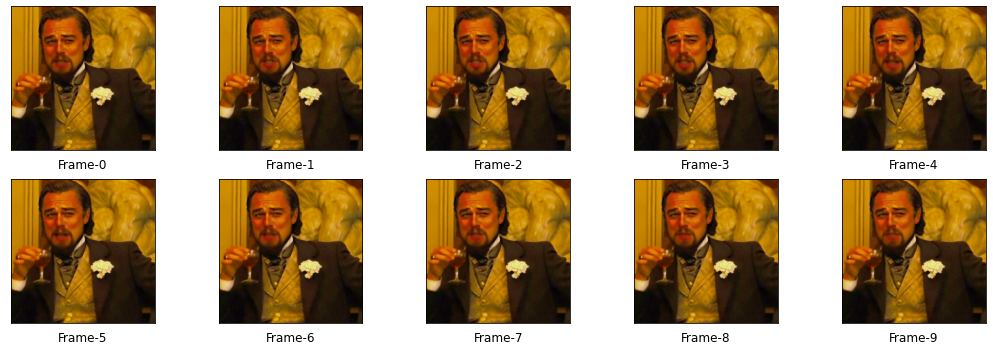

In [ ]:
# Function to read the first 10 frames of input video
def read_video_frames(video_file_path):
    # reading the first frame
    frames = []
    try:
        cap = cv2.VideoCapture(video_file_path)
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (224, 224))
        frames.append(frame)
    except:
        pass
    # while a next frame exists, we accumulate frames
    while ret:
        try:
            ret, frame = cap.read()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (224, 224))
            frames.append(frame)
        except:
            continue
    
    return frames[:10]


# Function to plot frames of a video
def plot_video(video_file_path, cols=5, ht=18):
    video_frames = read_video_frames(video_file_path)
    FRAMES = 10
    COLS = 5
    ROWS = (FRAMES//COLS)+1
    fig = plt.figure(figsize=(ht, 3*ROWS))
    for idx in range(FRAMES):
        ax = fig.add_subplot(ROWS, COLS, idx+1)
        ax.set_xticks([])
        ax.set_yticks([])

        ax.imshow(video_frames[idx])
        ax.text(0.5, -0.1, f'Frame-{str(idx):s}',
                size=12, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)



print("Random Sample from dataset\n")
random_row = df_train.iloc[random.choice(range(len(df_train)))]
print("Word  :  ", random_row[1])
plot_video(TRAIN_DATA_PATH+random_row[0])
plt.show()

###  

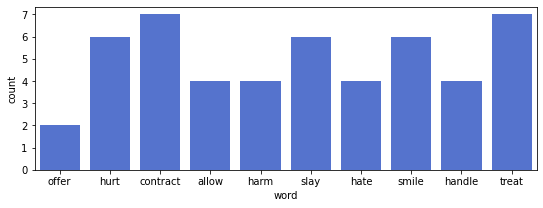

In [ ]:
# Plotting count of samples of random words in dataset

plt.figure(figsize=(9,3))
sns.countplot(x=df_train['word'],
              order=df_train['word'].value_counts().sample(10).index, 
              orient="h",
              color="royalblue")
plt.show()

  0%|          | 0/3000 [00:00<?, ?it/s]

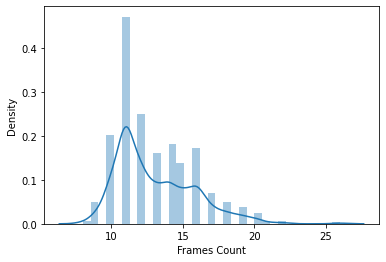

In [ ]:
def get_frames_count(video_file_path):
    cap = cv2.VideoCapture(video_file_path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    return length



frames_dist = []
for file in tqdm(os.listdir(TRAIN_DATA_PATH)):
    frames_dist.append(get_frames_count(TRAIN_DATA_PATH + file))

sns.distplot(frames_dist, kde=True)
plt.xlabel("Frames Count")
plt.show()

##   

In [ ]:
# Setting max number of frames to be extracted from each video

MAX_FRAMES = 20

In [ ]:
import mediapipe as mp


# Function to extract face region from first frame to
# pass to video_to_frames to extract face from all frames

def extract_face_roi(video_file_path):
    # capturing first frame of video
    cap = cv2.VideoCapture(video_file_path)
    print(video_file_path)
    # print('cap ',cap)
    ret, frame = cap.read()
    # print('frame ', frame)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image = frame
    image_size = (image.shape[0], image.shape[1])
    
    # initializing face detection model and detecting face
    mp_face_detection = mp.solutions.face_detection
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
        results = face_detection.process(image.astype(np.uint8))
        if not results.detections:
            raise Exception("No Face Error")
    
        for detection in results.detections:            
            bbox = detection.location_data.relative_bounding_box   
            xmin = int(bbox.xmin*image_size[1])
            ymin = int(bbox.ymin*image_size[0])
            width = int(bbox.width*image_size[1])
            height = int(bbox.height*image_size[0])
            roi_face = [xmin, ymin, width, height]
    return roi_face

In [ ]:
# Function to read all the MAX_FRAMES number of frames from the video
# Using the ROI coordinated from face exytraction model
# Finally grayscaling the frames

def video_to_frames(video_file_path, max_frames=30, IMAGE_SIZE = (224, 224), roi_face=None):
    frames = []
    try:
        cap = cv2.VideoCapture(video_file_path)
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if roi_face is not None:
            xmin, ymin, width, height = roi_face
            frame = frame[ymin:ymin + height, xmin:xmin + width]
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = cv2.resize(frame, IMAGE_SIZE)
        frames.append(frame)
    except:
        pass
    while ret:
        ret, frame = cap.read()
        try:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if roi_face is not None:
                xmin, ymin, width, height = roi_face
                frame = frame[ymin:ymin + height, xmin:xmin + width]
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame = cv2.resize(frame, IMAGE_SIZE)
            frames.append(frame)
        except:
            continue
    
    frames = frames[:max_frames]
    frames = np.array(frames)
    
    # adding padding to videos having less frames than MAX_FRAMES
    frames_count = frames.shape[0]
    if frames_count < max_frames:
        diff_frames = abs(max_frames-frames_count)
        zeroes_frame = np.zeros((1,)+IMAGE_SIZE)
        for _ in range(diff_frames):
            frames = np.append(frames, zeroes_frame, axis=0)
    
    assert frames.shape[0]==max_frames, "Fames Count != MAX_FRAMES"
    return frames

Random Sample from Processed dataset - Face Extracted

Word  :   occur
data/train/2469.mp4


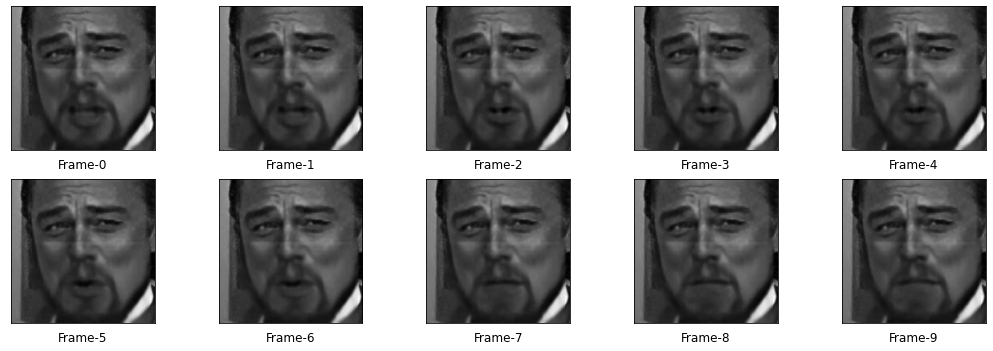

In [ ]:
# Function to plot frames of a video
def plot_video(video_file_path, cols=5, ht=18):
    roi_face = extract_face_roi(video_file_path)
    video_frames = video_to_frames(video_file_path, max_frames=MAX_FRAMES, roi_face=roi_face)
    FRAMES = 10
    COLS = 5
    ROWS = (FRAMES//COLS)+1
    fig = plt.figure(figsize=(ht, 3*ROWS))
    for idx in range(FRAMES):
        ax = fig.add_subplot(ROWS, COLS, idx+1)
        ax.set_xticks([])
        ax.set_yticks([])

        ax.imshow(video_frames[idx], cmap="gray")
        ax.text(0.5, -0.1, f'Frame-{str(idx):s}',
                size=12, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)




print("Random Sample from Processed dataset - Face Extracted\n")
random_row = df_train.iloc[random.choice(range(len(df_train)))]
print("Word  :  ", random_row[1])
plot_video(TRAIN_DATA_PATH+random_row[0])
plt.show()

In [ ]:
# Processing training data and writing to disk

TRAINVIDEOS_BASE_DIR = "data/train_videos/"
try:
    os.mkdir(TRAINVIDEOS_BASE_DIR)
    print("BASE_DIR Created")
except:
    pass

for video in tqdm(df_train['file_name']):
    # print('video ', video)
    file_name = TRAIN_DATA_PATH + video
    # print(file_name)
    roi_face = extract_face_roi(file_name)
    # print(roi_face)
    video_frames = video_to_frames(file_name, max_frames=MAX_FRAMES, roi_face=roi_face)

    try:
        video_dir = TRAINVIDEOS_BASE_DIR + str(video)
        os.mkdir(video_dir)
    except:
        continue

    for idx,frame in enumerate(video_frames):
        PIL_image = Image.fromarray(frame.astype('uint8'))
        PIL_image.save(video_dir + "/" + f'{idx:02d}' +".png")

BASE_DIR Created


  0%|          | 0/3000 [00:00<?, ?it/s]

data/train/0.mp4
data/train/1.mp4
data/train/2.mp4
data/train/3.mp4
data/train/4.mp4
data/train/5.mp4
data/train/6.mp4
data/train/7.mp4
data/train/8.mp4
data/train/9.mp4
data/train/10.mp4
data/train/11.mp4
data/train/12.mp4
data/train/13.mp4
data/train/14.mp4
data/train/15.mp4
data/train/16.mp4
data/train/17.mp4
data/train/18.mp4
data/train/19.mp4
data/train/20.mp4
data/train/21.mp4
data/train/22.mp4
data/train/23.mp4
data/train/24.mp4
data/train/25.mp4
data/train/26.mp4
data/train/27.mp4
data/train/28.mp4
data/train/29.mp4
data/train/30.mp4
data/train/31.mp4
data/train/32.mp4
data/train/33.mp4
data/train/34.mp4
data/train/35.mp4
data/train/36.mp4
data/train/37.mp4
data/train/38.mp4
data/train/39.mp4
data/train/40.mp4
data/train/41.mp4
data/train/42.mp4
data/train/43.mp4
data/train/44.mp4
data/train/45.mp4
data/train/46.mp4
data/train/47.mp4
data/train/48.mp4
data/train/49.mp4
data/train/50.mp4
data/train/51.mp4
data/train/52.mp4
data/train/53.mp4
data/train/54.mp4
data/train/55.mp4
da

In [ ]:
# Processing validation data and writing to disk

VALVIDEOS_BASE_DIR = "data/val_videos/"
try:
    os.mkdir(VALVIDEOS_BASE_DIR)
    print("BASE_DIR Created")
except:
    pass

for video in tqdm(df_val['file_name']):
    file_name = VAL_DATA_PATH + video
    roi_face = extract_face_roi(file_name)
    video_frames = video_to_frames(file_name, max_frames=MAX_FRAMES, roi_face=roi_face)

    try:
        video_dir = VALVIDEOS_BASE_DIR + str(video)
        os.mkdir(video_dir)
    except:
        continue

    for idx,frame in enumerate(video_frames):
        PIL_image = Image.fromarray(frame.astype('uint8'))
        PIL_image.save(video_dir + "/" + f'{idx:02d}' +".png")

BASE_DIR Created


  0%|          | 0/500 [00:00<?, ?it/s]

data/val/0.mp4
data/val/1.mp4
data/val/2.mp4
data/val/3.mp4
data/val/4.mp4
data/val/5.mp4
data/val/6.mp4
data/val/7.mp4
data/val/8.mp4
data/val/9.mp4
data/val/10.mp4
data/val/11.mp4
data/val/12.mp4
data/val/13.mp4
data/val/14.mp4
data/val/15.mp4
data/val/16.mp4
data/val/17.mp4
data/val/18.mp4
data/val/19.mp4
data/val/20.mp4
data/val/21.mp4
data/val/22.mp4
data/val/23.mp4
data/val/24.mp4
data/val/25.mp4
data/val/26.mp4
data/val/27.mp4
data/val/28.mp4
data/val/29.mp4
data/val/30.mp4
data/val/31.mp4
data/val/32.mp4
data/val/33.mp4
data/val/34.mp4
data/val/35.mp4
data/val/36.mp4
data/val/37.mp4
data/val/38.mp4
data/val/39.mp4
data/val/40.mp4
data/val/41.mp4
data/val/42.mp4
data/val/43.mp4
data/val/44.mp4
data/val/45.mp4
data/val/46.mp4
data/val/47.mp4
data/val/48.mp4
data/val/49.mp4
data/val/50.mp4
data/val/51.mp4
data/val/52.mp4
data/val/53.mp4
data/val/54.mp4
data/val/55.mp4
data/val/56.mp4
data/val/57.mp4
data/val/58.mp4
data/val/59.mp4
data/val/60.mp4
data/val/61.mp4
data/val/62.mp4
da

In [ ]:
# changing video name to filename including full path to feed into image generator

df_train['file_name'] = TRAINVIDEOS_BASE_DIR + df_train['file_name']
df_train.word = df_train.word.apply(lambda x:word2idx[x])
df_train.head(3)

,file_name,word
0,data/train_videos/0.mp4,176
1,data/train_videos/1.mp4,291
2,data/train_videos/2.mp4,100


In [ ]:
# changing video name to filename including full path to feed into image generator

df_val['file_name'] = VALVIDEOS_BASE_DIR + df_val['file_name']
df_val.word = df_val.word.apply(lambda x:word2idx[x])
df_val.head(3)

,file_name,word
0,data/val_videos/0.mp4,338
1,data/val_videos/1.mp4,321
2,data/val_videos/2.mp4,315


##   

In [ ]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df, X_col, y_col,num_classes,
                 input_size,
                 batch_size,
                 shuffle=True):
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.num_classes = num_classes
        self.input_size = input_size
        self.max_frames = input_size[0]
        self.image_size = input_size[1]
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        self.n = len(self.df)
        self.n_words = df[y_col].nunique()
        
    
    def on_epoch_end(self):
        # Shuffling data after each epoch
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)    
    
    def __len__(self):
        # Returns num of batches
        return self.n // self.batch_size
    
    
    
    def __get_frames(self,video_path):
        # Reads all frames from video folder
        frames_lst = []
        for img_name in sorted(os.listdir(video_path)):
            file_name = video_path + "/" +img_name
            frame = cv2.imread(file_name)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames_lst.append(frame)
        return np.array(frames_lst)


    def __get_input(self, path):
        # Returns of frames from video file
        video_frames = self.__get_frames(path) 
        return video_frames/255.
    
    
    def __get_output(self, label):
        # Encodes label using one-hot encoding
        return tf.keras.utils.to_categorical(label, num_classes=self.num_classes)
    
    
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples
        path_batch = batches[self.X_col]
        word_batch = batches[self.y_col]
        X_batch = np.asarray([self.__get_input(path) for path in path_batch])
        Y_batch = np.asarray([self.__get_output(word) for word in word_batch])
        return X_batch, Y_batch
    
    
    def __getitem__(self, index):
        # Returns a data item
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y

In [ ]:
# dimensions of the batch
TARGET_SIZE = (MAX_FRAMES, 224, 224, 1)

# number of images per batch
BATCH_SIZE = 4

# creating the training images generator
train_gen = CustomDataGen(df_train, 'file_name', 'word', NUM_CLASSES,
                          input_size=TARGET_SIZE,
                          batch_size=BATCH_SIZE)

# creating the validation images generator
val_gen = CustomDataGen(df_val, 'file_name', 'word', NUM_CLASSES,
                          input_size=TARGET_SIZE,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

In [ ]:
# viewing a random batch from the generator
random_sample_batch_imgs, random_sample_batch_labels = train_gen.__getitem__(random.choice(range(100)))

print("X_train shape:", random_sample_batch_imgs.shape)
print("Y_train shape:", random_sample_batch_labels.shape)

X_train shape: (4, 20, 224, 224)
Y_train shape: (4, 400)


###   

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv3D, MaxPool3D, BatchNormalization, GlobalAveragePooling3D, Flatten, Dropout


model = Sequential()

model.add(keras.Input((20, 224, 224,1)))
model.add(Conv3D(filters=64, kernel_size=2, activation="relu"))
model.add(MaxPool3D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv3D(filters=128, kernel_size=2, activation="relu"))
model.add(BatchNormalization())
          
model.add(Conv3D(filters=256, kernel_size=2, activation="relu"))
model.add(MaxPool3D(pool_size=2))
model.add(BatchNormalization())
          
model.add(Conv3D(filters=256, kernel_size=2, activation="relu"))
model.add(MaxPool3D(pool_size=2))
model.add(BatchNormalization())

model.add(GlobalAveragePooling3D())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(400, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 19, 223, 223, 64)  576       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 111, 111, 64)  0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 9, 111, 111, 64)  256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 110, 110, 128)  65664     
                                                                 
 batch_normalization_1 (Batc  (None, 8, 110, 110, 128)  512      
 hNormalization)                                                 
                                                        

In [ ]:
# creating an adam optimizer object with learning rate = 2e-3
optimizer = keras.optimizers.Adam(0.002)
# compiling model
model.compile(optimizer, 'categorical_crossentropy', metrics=['acc'])

In [ ]:
EPOCHS = 2 #try playing with different number of epochs and batch sizes to see how the score changes
BATCH_SIZE = 1

model.fit(train_gen, 
          validation_data = val_gen,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS)

In [ ]:
# saving the model
model.save(f"3D_CNN_{BATCH_SIZE}_{EPOCHS}.h5")

In [ ]:
# loaded_model = tf.keras.models.load_model('/content/3D_CNN_1_16.h5')
# loaded_model.summary()

In [ ]:
loaded_model = tf.keras.models.load_model('/content/3D_CNN_1_25.h5')
model.fit(train_gen, 
          validation_data = val_gen,
          batch_size=BATCH_SIZE,
          epochs=5)

# saving the model
model.save(f"3D_CNN_1_30.h5")

from google.colab import files
files.download(f"3D_CNN_1_30.h5")

Epoch 1/5
750/750 [==============================] - 395s 505ms/step - loss: 6.0965 - acc: 0.0050 - val_loss: 6.0355 - val_acc: 0.0020
Epoch 2/5
750/750 [==============================] - 387s 515ms/step - loss: 5.6770 - acc: 0.0110 - val_loss: 5.7200 - val_acc: 0.0060
Epoch 3/5
750/750 [==============================] - 386s 515ms/step - loss: 5.4585 - acc: 0.0127 - val_loss: 5.7694 - val_acc: 0.0040
Epoch 4/5
750/750 [==============================] - 386s 515ms/step - loss: 5.2892 - acc: 0.0150 - val_loss: 5.4381 - val_acc: 0.0060
Epoch 5/5
750/750 [==============================] - 385s 514ms/step - loss: 5.1394 - acc: 0.0200 - val_loss: 5.2370 - val_acc: 0.0080


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
loaded_model = tf.keras.models.load_model('/content/3D_CNN_1_30.h5')
model.fit(train_gen, 
          validation_data = val_gen,
          batch_size=BATCH_SIZE,
          epochs=10)

# saving the model
model.save(f"3D_CNN_1_40.h5")

from google.colab import files
files.download(f"3D_CNN_1_40.h5")

Epoch 1/10
750/750 [==============================] - 385s 514ms/step - loss: 4.9153 - acc: 0.0223 - val_loss: 5.2604 - val_acc: 0.0220
Epoch 2/10
750/750 [==============================] - 386s 514ms/step - loss: 4.7047 - acc: 0.0330 - val_loss: 4.5991 - val_acc: 0.0440
Epoch 3/10
750/750 [==============================] - 386s 514ms/step - loss: 4.5046 - acc: 0.0397 - val_loss: 4.3945 - val_acc: 0.0440
Epoch 4/10
750/750 [==============================] - 385s 514ms/step - loss: 4.2943 - acc: 0.0510 - val_loss: 4.2118 - val_acc: 0.0640
Epoch 5/10
750/750 [==============================] - 385s 514ms/step - loss: 4.1499 - acc: 0.0570 - val_loss: 4.2320 - val_acc: 0.0580
Epoch 6/10
750/750 [==============================] - 386s 514ms/step - loss: 4.0176 - acc: 0.0743 - val_loss: 3.6826 - val_acc: 0.0980
Epoch 7/10
750/750 [==============================] - 386s 514ms/step - loss: 3.7858 - acc: 0.0993 - val_loss: 3.6641 - val_acc: 0.1380
Epoch 8/10
750/750 [============================

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
loaded_model = tf.keras.models.load_model('/content/3D_CNN_1_50.h5')
model.fit(train_gen, 
          validation_data = val_gen,
          batch_size=BATCH_SIZE,
          epochs=10)

# saving the model
model.save(f"3D_CNN_1_60.h5")

Epoch 1/10
750/750 [==============================] - 386s 514ms/step - loss: 1.2134 - acc: 0.6373 - val_loss: 0.8282 - val_acc: 0.6960
Epoch 2/10
750/750 [==============================] - 386s 514ms/step - loss: 1.0719 - acc: 0.6550 - val_loss: 0.5460 - val_acc: 0.8240
Epoch 3/10
750/750 [==============================] - 386s 514ms/step - loss: 1.0083 - acc: 0.6727 - val_loss: 0.8930 - val_acc: 0.7640
Epoch 4/10
750/750 [==============================] - 385s 514ms/step - loss: 0.9624 - acc: 0.7057 - val_loss: 1.0994 - val_acc: 0.7060
Epoch 5/10
750/750 [==============================] - 386s 514ms/step - loss: 0.8616 - acc: 0.7160 - val_loss: 0.4544 - val_acc: 0.8540
Epoch 6/10
750/750 [==============================] - 385s 514ms/step - loss: 0.8113 - acc: 0.7487 - val_loss: 0.4921 - val_acc: 0.8500
Epoch 7/10
750/750 [==============================] - 386s 514ms/step - loss: 0.7336 - acc: 0.7637 - val_loss: 0.7622 - val_acc: 0.7920
Epoch 8/10
750/750 [============================

In [ ]:
from google.colab import files
files.download(f"3D_CNN_1_60.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
loaded_model = tf.keras.models.load_model('/content/3D_CNN_1_60.h5')
model.fit(train_gen, 
          validation_data = val_gen,
          batch_size=BATCH_SIZE,
          epochs=10)

# saving the model
model.save(f"3D_CNN_1_70.h5")

In [ ]:
from google.colab import files
files.download(f"3D_CNN_1_70.h5")

In [ ]:
# # saving the model
# model.save(f"3D_CNN_1_20.h5")

# from google.colab import files
# files.download(f"3D_CNN_1_20.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Plotting the training and validation loss against the number of epochs, 
# A decreasing trend for both training and validation indicates a good model training.

# metrics = pd.DataFrame(model.history.history)
# metrics[["loss","val_loss"]].plot()
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.show()

In [ ]:
# Plotting the training and validation accuracy against the number of epochs, 
# an increasing trend for both these lines also indicates a good model training.

# metrics[["accuracy","val_accuracy"]].plot()
# plt.xlabel('Epocs')
# plt.ylabel('Accuracy')
# plt.show()

In [ ]:
# loading model
model = keras.models.load_model('/content/3D_CNN_1_60.h5')

# evaluating on validation data
model.evaluate(val_gen)

125/125 [==============================] - 19s 150ms/step - loss: 0.3391 - acc: 0.9000


[0.33907514810562134, 0.8999999761581421]

In [ ]:
# Making predictions on validation data

predictions = model.predict(val_gen, verbose=1)
y_val_pred = predictions.argmax(axis=1)
y_true_val = df_val['word']

125/125 [==============================] - 19s 150ms/step


In [ ]:
# evaluating prediction on mentioned metrics
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import accuracy_score,f1_score

print('Accuracy :', round(accuracy_score(y_true_val, y_val_pred)*100,3),"%")
print('Precision:', round(precision_score(y_true_val, y_val_pred, average='macro')*100,3),"%")
print('Recall   :', round(recall_score(y_true_val, y_val_pred, average='macro')*100,3),"%")
print('F1-score :', round(f1_score(y_true_val, y_val_pred, average='macro')*100,3),"%")

Accuracy : 90.0 %
Precision: 84.399 %
Recall   : 84.781 %
F1-score : 83.564 %


##   

In [ ]:
from google.colab import files
files.download(f"3D_CNN_{BATCH_SIZE}_{EPOCHS}.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>